In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model
import time
import random
import copy
import math


result for question 2 is 
-------------------------
The demand is  [  4.63239     20.1715       7.84986      2.20323      9.41249
  38.86684571 163.93907937   6.97208318  13.97773978  32.47670205]
The real distribution is  [125 144 127 119 131 256 512 119 131 256]
The best score is  60825574.80257312
[5.798824039073019, 5.826940795248538, 5.788742127391953, 5.76896085148673, 5.808825142292821, 6.385105675823139, 6.855246464652676, 5.727634839745699, 5.7708732525680375, 6.4139794788673505]

result for question 3 is 
-------------------------
The demand is  [  4.63239     20.1715       7.84986      2.20323      9.41249
  38.86684571 163.93907937   6.97208318  13.97773978  32.47670205]
The real distribution is  [ 30.3  52.4  37.3  27.2  39.6  99.1 199.5  29.6  55.5  69.5]
640.0 640.0
The best score is  3117646.697863957
[4.309360197354534, 4.326060675414714, 4.372459715529393, 4.36026322807453, 4.452761789295188, 5.5012880690729675, 4.369394338011981, 4.219991874838639, 4.332999202019158,

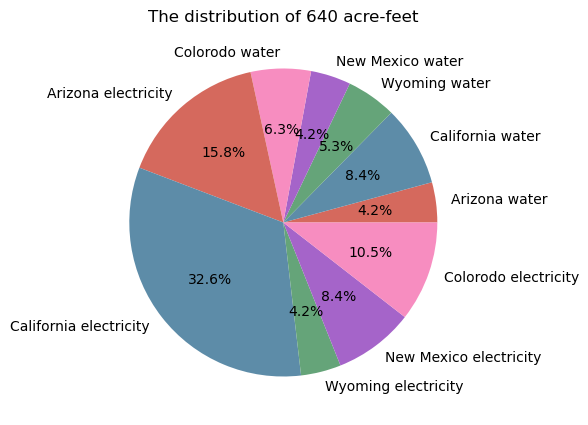

The demand is  [  4.63239     20.1715       7.84986      2.20323      9.41249
  38.86684571 163.93907937   6.97208318  13.97773978  32.47670205]
The real distribution is  [ 2.7        12.6         5.5         1.9         6.3        17.
 18.6         3.9         6.4         8.29130435]
83.47826086956522 83.19130434782609
The best score is  5.5952868977670775e-95
[0.07190640040980391, 0.00028259380765577715, 0.0212827158100297, 0.8160905190189863, 0.00022207619816636947, 2.354716003268827e-09, 8.362701244067843e-63, 0.0188341573877921, 0.0001261877368991148, 1.52537390806448e-08]


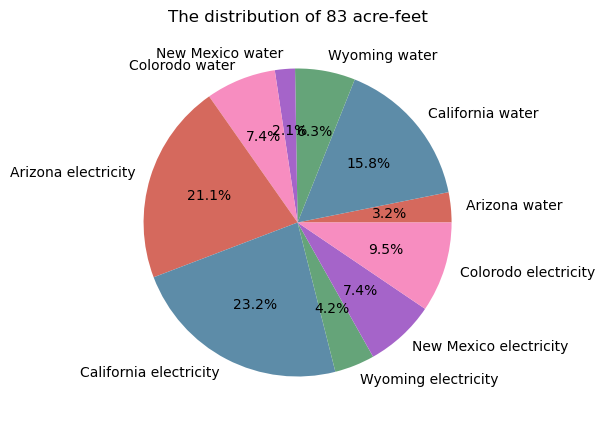

The demand is  [  4.63239     20.1715       7.84986      2.20323      9.41249
  38.86684571 163.93907937   6.97208318  13.97773978  32.47670205]
The real distribution is  [ 2.6       10.2        3.2        1.7        5.1        6.7
  6.         2.9        3.1        2.8255814]
44.651162790697676 44.325581395348834
The best score is  4.005267337826508e-112
[0.19546186158387002, 7.004800158391918e-07, 0.007829473598804346, 0.8160905190189863, 0.24353612260697002, 7.20313089522719e-16, 2.805373735698604e-66, 0.0025489260245997853, 1.7077653114228863e-05, 2.137184383365515e-14]


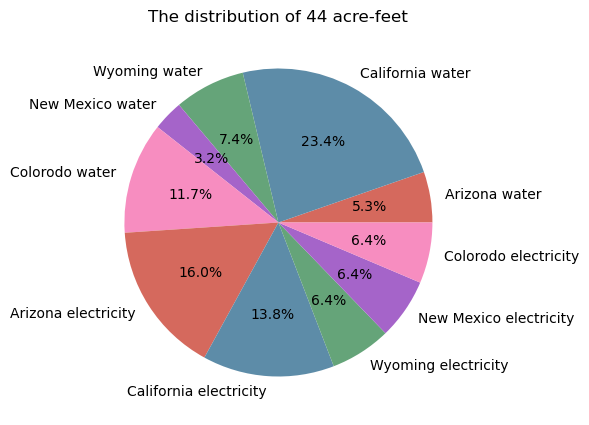

The demand is  [  4.63239     20.1715       7.84986      2.20323      9.41249
  38.86684571 163.93907937   6.97208318  13.97773978  32.47670205]
The real distribution is  [2.8        5.5        2.7        1.7        3.7        3.4
 2.2        2.9        2.7        2.68571429]
30.476190476190474 30.285714285714278
The best score is  3.330494819090232e-118
[0.5313204265002109, 2.5769219677868496e-07, 0.0212827158100297, 0.300222924082017, 0.000603665694008912, 7.20313089522719e-16, 4.685451273845178e-71, 0.05119654778157295, 6.282517484182256e-06, 5.80946947336893e-14]


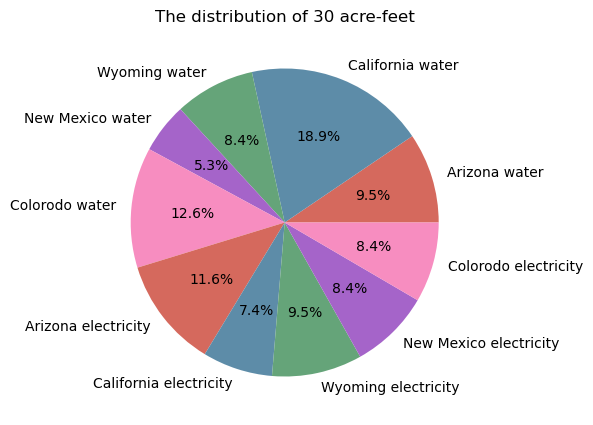

The demand is  [  4.63239     20.1715       7.84986      2.20323      9.41249
  38.86684571 163.93907937   6.97208318  13.97773978  32.47670205]
The real distribution is  [2.3        3.3        2.5        1.5        2.6        2.3
 3.4        2.7        2.1        0.41927711]
23.132530120481928 23.119277108433735
The best score is  3.4674043452413e-121
[0.19546186158387002, 5.1758861332156184e-06, 0.0028803023721947043, 0.300222924082017, 0.00022207619816636947, 2.6498837684209295e-16, 1.7236811962581868e-71, 0.00692869929475595, 6.282517484182256e-06, 8.976449876877605e-15]


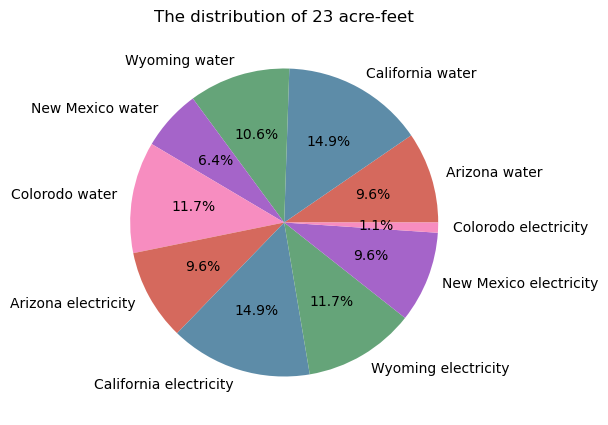

In [2]:
m=10

M_v = 3000.976144195105 - -940.9125903639906
P_v = 2446.5858645842236 - 197.10793241368083
A = eval("""[4632.39
    20171.5
    7849.86
    2203.23
    9412.49]""".replace('\n', ','))
B = pd.read_csv('./elec_usage.csv')['Elec Consumption(in billion kwh)']
N = int((M_v + P_v)/3.22321112134556)
bitlength = N.bit_length()
N_GENERATIONS=10000



def e2w(y): return np.exp((y + 4.4675) / 1.1370)
def get_a_prime(A, B):
    ratio = B/sum(B)
    return np.append(A, e2w(np.sum(B)) * ratio)

def genetic_algorithm(a_prime, m, N):
    global bitlength, A, B, N_GENERATIONS
    def score(ai, a_primei, m):
        value = (ai-a_primei)
        if value > 0:
            return np.log(value+1)+1
        else:
            return np.exp(value)

    def evaluate(a, a_prime, m):
        summation = 1
        for i in range(len(a)):
            summation = summation * score(a[i], a_prime[i], m)
        return (summation)

    def init_random():
        x, tmp = [], []
        while len(tmp) < 9:
            r = random.randint(0, int(N))
            if r not in tmp and r != 0 and r != N:
                tmp.append(r)
        tmp.sort()
        x.append(tmp[0])
        for i in range(1, 9):
            x.append(tmp[i]-tmp[i-1])
        x.append(N-tmp[-1])
        return x

    def swap(x):
        new_x = copy.copy(x)
        x_copy = copy.copy(x)
        x = list(x)
        np.random.shuffle(x_copy)
        bitlength = int(N).bit_length()
        s = random.randint(0, bitlength-1)
        new_x[x.index(x_copy[0])] = int((bin(int(x_copy[0]))[2:]).zfill(bitlength)[:s] + bin(int(x_copy[1]))[2:].zfill(bitlength)[s:],2)
        new_x[x.index(x_copy[1])] = int(bin(int(x_copy[1]))[2:].zfill(bitlength)[:s] + bin(int(x_copy[0]))[2:].zfill(bitlength)[s:],2)
        return new_x

    def mutation(x):
        new_x = copy.copy(x)
        x_copy = copy.copy(x)
        ridx = random.randint(0, len(x_copy)-1)
        r = random.randint(0, bitlength-1)
        x_copy_bin = (bin(int(x_copy[ridx]))[2:]).zfill(bitlength)
        x_copy_bin = x_copy_bin[:r] + str((int(x_copy_bin[r])+1) % 2) + x_copy_bin[r+1:]
        new_x[ridx] = int(x_copy_bin, 2)
        return new_x

    def legal(x):
        if 0 in x:
            return False
        s = sum(x)
        if s > N:
            return False
        else:
            return True

    ## main part
    best_score = -999999
    next_x = init_random()
    best = next_x
    for _ in range(N_GENERATIONS):
        x = next_x
        y = swap(x)
        if not legal(y):
            y = x
        y_score = evaluate(y, a_prime, m)
        if y_score > best_score:
            best_score = y_score
            best = y
        z = mutation(y)
        if not legal(z):
            z = y
        z_score = evaluate(z, a_prime, m)
        if z_score > best_score:
            best_score = z_score
            best = z
        next_x = best
    best = np.array(best)
    return best, best_score, [score(best[i], a_prime[i], m) for i in range(len(best))]
def main():
    # import 2019 data
    global N, bitlength, A, B, N_GENERATIONS
    A, B = np.array(A), np.array(B)
    A = A / 1e3
    B = B / 365
    a_prime = get_a_prime(A, B)
    best, best_score, score_list = genetic_algorithm(a_prime, m, N)

    ### print result
    print("result for question 2 is ")
    print("-------------------------")
    print("The demand is ", a_prime)
    print("The real distribution is ", best)
    print("The best score is " ,best_score )
    print([score_list[i] for i in range(len(best))])

    ### then simulate question C:
    print()
    print("result for question 3 is ")
    print("-------------------------")
    plt.ion()
    N_copy = N
    dividers = np.arange(3, 100, 1) ### 2.01 at question 2
    for idx, divider in enumerate(dividers):
        if (idx % 20 == 0):
            N_copy = N / divider
            best = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
            for iter in range(10):
                best_, best_score, score_list = genetic_algorithm(a_prime, m, N_copy)
                best = best + best_
            best = best / 10
            percentage = best / N_copy * 100
            percentage = [int(i) for i in percentage]
            print("The demand is ", a_prime)
            print("The real distribution is ", best)
            print(N_copy, sum(best))
            print("The best score is " ,best_score )
            print([score_list[i] for i in range(len(best))])
            plt.figure(figsize=(5, 5))
            plt.pie(percentage, colors= ["#d5695d", "#5d8ca8", "#65a479", "#a564c9", "#f78dc0", "#d5695d", "#5d8ca8", "#65a479", "#a564c9", "#f78dc0"], labels = ['Arizona water', 'California water', 'Wyoming water', 'New Mexico water', 'Colorodo water', 'Arizona electricity', 'California electricity', 'Wyoming electricity', 'New Mexico electricity', 'Colorodo electricity'], autopct='%1.1f%%')
            plt.title("The distribution of " + str(int(N_copy)) + " acre-feet")
            plt.show()
    plt.ioff()
main()